In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import numpy as np
%matplotlib inline
plt.style.use('ggplot') 

# Fundamental Data

In [2]:
# Create a database connection
user = 'postgres'
host = 'localhost'
dbname = 'mimic'
schema = 'mimiciii'

In [230]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))

Password:········


We follow the paper 

Predicting Mortality in Diabetic ICU Patients Using Machine Learning and Severity Indices: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5961793/

In [7]:
# Get feature according to the paper
query = \
"""
with db_patience as
(select di.hadm_id,di.subject_id
from diagnoses_icd di
where di.ICD9_CODE ~* '^25[0-9][0-9][0-9]'
or di.ICD9_CODE ~* '^249[0-9][0-9]'
or di.ICD9_CODE ~* '^3572'
or di.ICD9_CODE ~* '^3620'
or di.ICD9_CODE ~* '^36641'
or di.ICD9_CODE ~* '^6484'
group by 1,2
)
,lab_aggs as
(
select le.hadm_id,le.subject_id
, min(case when dlab.loinc_code='4548-4' then le.valuenum else null end) as HbA1c_min
, max(case when dlab.loinc_code='4548-4' then le.valuenum else null end) as HbA1c_max
, avg(case when dlab.loinc_code='4548-4' then le.valuenum else null end) as HbA1c_mean
, min(case when dlab.loinc_code='2345-7' then le.valuenum else null end) as lab_glucose_min
, max(case when dlab.loinc_code='2345-7' then le.valuenum else null end) as lab_glucose_max
, avg(case when dlab.loinc_code='2345-7' then le.valuenum else null end) as lab_glucose_mean
, min(case when dlab.loinc_code='2160-0' then le.valuenum else null end) as serum_creatinine_min
, max(case when dlab.loinc_code='2160-0' then le.valuenum else null end) as serum_creatinine_max
, avg(case when dlab.loinc_code='2160-0' then le.valuenum else null end) as serum_creatinine_mean
from labevents le inner join d_labitems dlab
on le.itemid = dlab.itemid
group by 1,2 order by 1,2
)





select dbp.hadm_id,dbp.subject_id, ad.admittime, ad.dischtime, ad.deathtime
, ie.first_careunit, ie.last_careunit
, extract(epoch from (ad.admittime - p.dob))/60.0/60.0/24.0/365.242 as age
, p.gender as gender
, ad.marital_status as marital_status
, ad.admission_type
, ad.ethnicity
, ad.insurance as insurance
,HbA1c_min
,HbA1c_max
,HbA1c_mean
,lab_glucose_min
,lab_glucose_max
,lab_glucose_mean
,la.serum_creatinine_min
,la.serum_creatinine_max
,la.serum_creatinine_mean


from db_patience dbp
inner join lab_aggs la
on dbp.hadm_id = la.hadm_id
inner join patients p
on la.subject_id = p.subject_id
inner join admissions ad
on la.hadm_id = ad.hadm_id
inner join icustays ie
on la.hadm_id = ie.hadm_id
where HbA1c_mean is not null
and lab_glucose_mean is not null

group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
order by 1,2


;
"""

data = pd.read_sql_query(query,con)
print(data.shape)
data.head()

(2915, 22)


,hadm_id,subject_id,admittime,dischtime,deathtime,first_careunit,last_careunit,age,gender,marital_status,...,insurance,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean
0,100009,533,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,CSRU,CSRU,60.797126,M,MARRIED,...,Private,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333
1,100059,20777,2198-02-01 20:06:00,2198-02-19 13:10:00,NaT,CSRU,CSRU,68.266622,M,MARRIED,...,Medicare,7.1,7.1,7.1,100.0,254.0,140.000000,0.5,1.2,0.881818
2,100065,27892,2147-06-08 22:55:00,2147-06-12 18:00:00,NaT,MICU,MICU,59.223624,M,MARRIED,...,Private,13.7,13.7,13.7,119.0,360.0,229.250000,1.2,1.8,1.308333
3,100068,9889,2192-01-05 15:35:00,2192-01-20 17:29:00,NaT,CSRU,CSRU,74.319627,F,WIDOWED,...,Medicare,7.0,7.0,7.0,60.0,385.0,190.923077,2.4,6.3,4.307692
4,100114,1900,2157-09-18 09:07:00,2157-10-06 13:30:00,NaT,SICU,SICU,50.630486,M,MARRIED,...,Medicare,11.0,11.0,11.0,121.0,327.0,176.083333,2.1,3.4,2.825000


In [8]:
# Assign Death label from the availability of deathtime
data['Death'] = (~ np.isnat(data['deathtime'])).astype(int)
data.head()

,hadm_id,subject_id,admittime,dischtime,deathtime,first_careunit,last_careunit,age,gender,marital_status,...,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean,Death
0,100009,533,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,CSRU,CSRU,60.797126,M,MARRIED,...,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333,0
1,100059,20777,2198-02-01 20:06:00,2198-02-19 13:10:00,NaT,CSRU,CSRU,68.266622,M,MARRIED,...,7.1,7.1,7.1,100.0,254.0,140.000000,0.5,1.2,0.881818,0
2,100065,27892,2147-06-08 22:55:00,2147-06-12 18:00:00,NaT,MICU,MICU,59.223624,M,MARRIED,...,13.7,13.7,13.7,119.0,360.0,229.250000,1.2,1.8,1.308333,0
3,100068,9889,2192-01-05 15:35:00,2192-01-20 17:29:00,NaT,CSRU,CSRU,74.319627,F,WIDOWED,...,7.0,7.0,7.0,60.0,385.0,190.923077,2.4,6.3,4.307692,0
4,100114,1900,2157-09-18 09:07:00,2157-10-06 13:30:00,NaT,SICU,SICU,50.630486,M,MARRIED,...,11.0,11.0,11.0,121.0,327.0,176.083333,2.1,3.4,2.825000,0


In [9]:
# number of alive and death subject
data['Death'].value_counts()

0    2736
1     179
Name: Death, dtype: int64

# Diabetes complications severity index (DCSI) 

In [ ]:
# Gain data from diagnoses_icd to create DCSI score

In [10]:
query = \
"""
SELECT di.hadm_id,di.subject_id, di.ICD9_CODE
FROM diagnoses_icd di;
"""

diag = pd.read_sql_query(query,con)

In [11]:
diag.head()

,hadm_id,subject_id,icd9_code
0,172335,109,40301
1,172335,109,486
2,172335,109,58281
3,172335,109,5855
4,172335,109,4254


In [12]:
diag.shape

(651047, 3)

In [17]:
#Using eliminate hadm_id in diagnosis dataset that is not in our diabetic data. 
diag = diag[diag['hadm_id'].isin(data['hadm_id'])];

In [18]:
diag.head()

,hadm_id,subject_id,icd9_code
110,195632,123,41011
111,195632,123,41401
112,195632,123,4019
113,195632,123,25000
114,195632,123,3051


In [19]:
diag.shape

(38819, 3)

Create DCSI severity score according to the paper Diabetes complications severity index and risk of mortality, hospitalization, and healthcare utilization. https://www.ncbi.nlm.nih.gov/pubmed/18197741

In [202]:
def severity_score(df):
    
    data = np.asarray(df['icd9_code']);
    scores = np.zeros([7]);
    
    for item in data:
    
        if re.match(r'^2505[0-9]$',item) or  re.match(r'^36201$',item) or  re.match(r'^3621$',item) or  re.match(r'^36283$',item) or  re.match(r'^336253$',item) or  re.match(r'^36281$',item) or  re.match(r'^36282$',item) :
            scores[0]=max(scores[0],1);
        elif re.match(r'^36202$',item) or  re.match(r'^361[0-9][0-9]$',item) or  re.match(r'^369[0-9][0-9]$',item) or  re.match(r'^37923$',item):
            scores[0]=max(scores[0],2);
        elif re.match(r'^2504$',item) or  re.match(r'^580$',item) or  re.match(r'^581$',item) or  re.match(r'^58181$',item) or  re.match(r'^582$',item) or  re.match(r'^583$',item) :
            scores[1]=max(scores[1],1);
        elif re.match(r'^585$',item) or  re.match(r'^586$',item) or  re.match(r'^5939$',item):
            scores[1]=max(scores[1],2);
        else:
            pattern3 = [r'^3569$',r'^2506$',r'^3581$',r'^9510$',r'^9511$',r'^9513$',r'^35[4-5][0-9]$',r'^7135$',r'^3572$',r'^59654$',r'^337[0-1]$',r'^5645$',r'^5363$',r'^4580$'];
            for p in pattern3:
                if(re.match(p,item)):
                    scores[2]=max(scores[2],1);
        if re.match(r'^435$',item):
            scores[3]=max(scores[3],1);
        elif  re.match(r'^43[1,3,4,6]$',item):
            scores[3]=max(scores[3],2);
        elif re.match(r'^440[0-9][0-9]$',item) or  re.match(r'^41[1,3,4]$',item) or  re.match(r'^4292$',item):
            scores[4]=max(scores[4],1);
        elif re.match(r'^410$',item) or re.match(r'^427[1,3]$',item) or re.match(r'^427[4,5]$',item)or re.match(r'^412$',item)or re.match(r'^428$',item)or re.match(r'^4402[3,4]$',item)or re.match(r'^441$',item):
            scores[4]=max(scores[4],2);
        elif  re.match(r'^2507$',item) or re.match(r'^4423$',item) or re.match(r'^44381$',item) or re.match(r'^4439$',item) or re.match(r'^8921$',item):
            scores[5]=max(scores[5],1);
        elif  re.match(r'^44422$',item) or re.match(r'^7854$',item) or re.match(r'^040$',item) or re.match(r'^7071$',item):
            scores[5]=max(scores[5],2);
        elif  re.match(r'^250[1,2,3]$',item):
            scores[6]=max(scores[6],2);
            
    total_score = np.sum(scores)-scores[1];        
            
    return [scores[1],np.sum(scores)]


dcsi_score=diag.groupby(['hadm_id']).apply(severity_score)

In [205]:
# Create dataframe from series 
# The output will be the sum of 1,3-7 categories and the score for 2 category which need serum measurement to make
# the calculation complete
dcsi_score = pd.DataFrame({'hadm_id':dcsi_score.index, 'score':dcsi_score.values})
dcsi_score.head()

,hadm_id,score
0,100009,"[0.0, 1.0]"
1,100059,"[0.0, 0.0]"
2,100065,"[0.0, 0.0]"
3,100068,"[0.0, 2.0]"
4,100114,"[0.0, 1.0]"


In [206]:
# Create serum measurement data set
serum_df = data[['hadm_id','serum_creatinine_mean']]
serum_df.head()

,hadm_id,serum_creatinine_mean
0,100009,0.783333
1,100059,0.881818
2,100065,1.308333
3,100068,4.307692
4,100114,2.825000


In [207]:
# merge the dcsi score and serum dataframe
dcsi_score = pd.merge(dcsi_score, serum_df, how='inner', on=['hadm_id'])
dcsi_score.head()

,hadm_id,score,serum_creatinine_mean
0,100009,"[0.0, 1.0]",0.783333
1,100059,"[0.0, 0.0]",0.881818
2,100065,"[0.0, 0.0]",1.308333
3,100068,"[0.0, 2.0]",4.307692
4,100114,"[0.0, 1.0]",2.825000


In [208]:
# Calculate the final score

def final_severity_score(df):
    
    score = np.asarray(df['score']);
    serum =df['serum_creatinine_mean'];
    if(serum>=2):
        add = 2;
    elif (serum>=1.5):
        add = 1;
    else:
        add =0;
        
    df['DCSI'] = score[1]+add
    return df

dcsi_score = dcsi_score.apply(final_severity_score,axis=1)
dcsi_score.head(20)

,hadm_id,score,serum_creatinine_mean,DCSI
0,100009,"[0.0, 1.0]",0.783333,1.0
1,100059,"[0.0, 0.0]",0.881818,0.0
2,100065,"[0.0, 0.0]",1.308333,0.0
3,100068,"[0.0, 2.0]",4.307692,4.0
4,100114,"[0.0, 1.0]",2.825000,3.0
5,100139,"[0.0, 2.0]",5.950000,4.0
6,100166,"[0.0, 1.0]",0.588889,1.0
7,100173,"[0.0, 0.0]",0.477778,0.0
8,100184,"[0.0, 3.0]",1.090909,3.0
9,100265,"[0.0, 1.0]",0.836364,1.0


In [209]:
dcsi_score = dcsi_score[['hadm_id','DCSI']]

In [210]:
# Join the dcsi and diabetic data
join_dcsi = pd.merge(dcsi_score, data, how='inner', on=['hadm_id'])

In [211]:
join_dcsi['DCSI'].value_counts()

0.0    1366
2.0     744
1.0     504
3.0     275
4.0     180
5.0      76
6.0      30
7.0      10
8.0       2
Name: DCSI, dtype: int64

In [212]:
join_dcsi

,hadm_id,DCSI,subject_id,admittime,dischtime,deathtime,first_careunit,last_careunit,age,gender,...,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean,Death
0,100009,1.0,533,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,CSRU,CSRU,60.797126,M,...,7.9,7.9,7.900,151.0,263.0,198.800000,0.7,0.8,0.783333,0
1,100059,0.0,20777,2198-02-01 20:06:00,2198-02-19 13:10:00,NaT,CSRU,CSRU,68.266622,M,...,7.1,7.1,7.100,100.0,254.0,140.000000,0.5,1.2,0.881818,0
2,100065,0.0,27892,2147-06-08 22:55:00,2147-06-12 18:00:00,NaT,MICU,MICU,59.223624,M,...,13.7,13.7,13.700,119.0,360.0,229.250000,1.2,1.8,1.308333,0
3,100068,4.0,9889,2192-01-05 15:35:00,2192-01-20 17:29:00,NaT,CSRU,CSRU,74.319627,F,...,7.0,7.0,7.000,60.0,385.0,190.923077,2.4,6.3,4.307692,0
4,100114,3.0,1900,2157-09-18 09:07:00,2157-10-06 13:30:00,NaT,SICU,SICU,50.630486,M,...,11.0,11.0,11.000,121.0,327.0,176.083333,2.1,3.4,2.825000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3182,199961,2.0,20620,2115-06-29 00:03:00,2115-07-12 13:50:00,NaT,SICU,SICU,58.462614,M,...,7.1,7.1,7.100,66.0,209.0,132.800000,3.2,4.1,3.545455,0
3183,199963,2.0,5478,2101-08-23 16:43:00,2101-09-08 13:30:00,NaT,CCU,CCU,70.467516,M,...,6.0,6.3,6.125,66.0,217.0,125.600000,2.0,4.1,3.237931,0
3184,199967,0.0,42131,2184-07-31 16:22:00,2184-08-10 12:15:00,NaT,SICU,SICU,82.577255,F,...,5.8,5.8,5.800,94.0,122.0,106.454545,0.6,0.8,0.681818,0
3185,199979,0.0,41115,2182-02-05 03:30:00,2182-02-10 14:50:00,NaT,CSRU,CSRU,79.470997,M,...,5.7,5.7,5.700,101.0,160.0,132.250000,0.7,1.0,0.800000,0


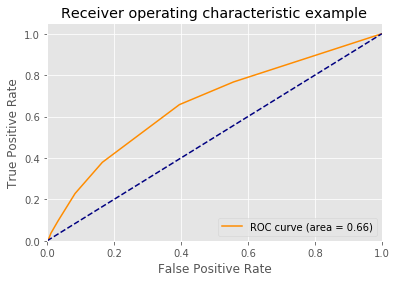

In [213]:
y_test = np.asarray(join_dcsi['Death']);
y_score= np.asarray(join_dcsi['DCSI']);
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# ELIXHAUSER SCORE


We use SQL relation (ELIXHAUSER_QUAN_SCORE) created using SQL code from https://github.com/MIT-LCP/mimic-code

In [164]:
query = \
"""
SELECT *
FROM ELIXHAUSER_QUAN_SCORE;
"""

eli = pd.read_sql_query(query,con)



In [161]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))

Password:········


In [165]:
eli.head()

,hadm_id,elixhauser_vanwalraven,elixhauser_sid29,elixhauser_sid30
0,100001,5.0,5.0,6.0
1,100003,11.0,4.0,5.0
2,100006,11.0,11.0,22.0
3,100007,0.0,-1.0,-2.0
4,100009,-2.0,-2.0,5.0


In [167]:
join_eli = pd.merge(eli, data, how='inner', on=['hadm_id'])
join_eli.head()

,hadm_id,elixhauser_vanwalraven,elixhauser_sid29,elixhauser_sid30,subject_id,admittime,dischtime,deathtime,first_careunit,last_careunit,...,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean,Death
0,100009,-2.0,-2.0,5.0,533,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,CSRU,CSRU,...,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333,0
1,100059,0.0,-2.0,-2.0,20777,2198-02-01 20:06:00,2198-02-19 13:10:00,NaT,CSRU,CSRU,...,7.1,7.1,7.1,100.0,254.0,140.000000,0.5,1.2,0.881818,0
2,100065,0.0,-1.0,-2.0,27892,2147-06-08 22:55:00,2147-06-12 18:00:00,NaT,MICU,MICU,...,13.7,13.7,13.7,119.0,360.0,229.250000,1.2,1.8,1.308333,0
3,100068,14.0,18.0,27.0,9889,2192-01-05 15:35:00,2192-01-20 17:29:00,NaT,CSRU,CSRU,...,7.0,7.0,7.0,60.0,385.0,190.923077,2.4,6.3,4.307692,0
4,100114,5.0,5.0,5.0,1900,2157-09-18 09:07:00,2157-10-06 13:30:00,NaT,SICU,SICU,...,11.0,11.0,11.0,121.0,327.0,176.083333,2.1,3.4,2.825000,0


## There are 3 type of elixhauser score, we then test all and choose the best score.

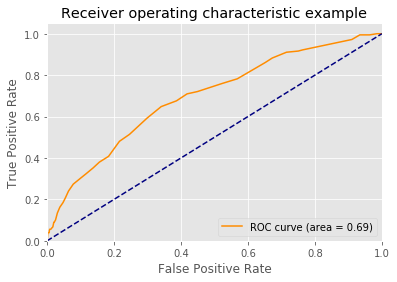

In [185]:
# Using elixhauser_vanwalraven

join_eli_vanwalraven= join_eli[['Death','elixhauser_vanwalraven']];
join_eli_vanwalraven=join_eli_vanwalraven.dropna()

y_test = np.asarray(join_eli_vanwalraven['Death']);
y_score= np.asarray(join_eli_vanwalraven['elixhauser_vanwalraven']);
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

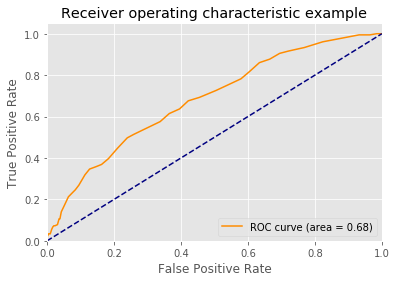

In [187]:
# Using elixhauser_29

join_eli_29= join_eli[['Death','elixhauser_sid29']];
join_eli_29=join_eli_29.dropna()

y_test = np.asarray(join_eli_29['Death']);
y_score= np.asarray(join_eli_29['elixhauser_sid29']);
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

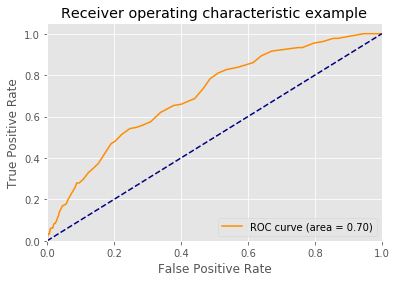

In [188]:
# Using elixhauser_30

join_eli_30= join_eli[['Death','elixhauser_sid30']];
join_eli_30=join_eli_30.dropna()

y_test = np.asarray(join_eli_30['Death']);
y_score= np.asarray(join_eli_30['elixhauser_sid30']);
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Charlson comorbidity score (CCS)

We follow the proceduce in R code from https://cran.r-project.org/web/packages/comorbidity/vignettes/comorbidityscores.html to create the CCS score

## Using SQL query to create CCS category

In [231]:
query = \
"""

with
icd as
(
  select hadm_id, seq_num
    , cast(icd9_code as char(5)) as icd9_code
  from diagnoses_icd
)
,
eliflg as
(
select hadm_id, seq_num, icd9_code
-- note that these codes will seem incomplete at first
-- for example, CHF is missing a lot of codes referenced in the literature (402.11, 402.91, etc)
-- these codes are captured by hypertension flags instead
-- later there are some complicated rules which confirm/reject those codes as CHF
, CASE
  when icd9_code between '4100 ' and '4109 ' then 1
  when icd9_code between '4120 ' and '4129 ' then 1
    end as MI /* Myocardial infarction */      
, case
    when icd9_code = '39891' then 1
    when icd9_code = '40201' then 1
    when icd9_code = '40211' then 1
    when icd9_code = '40291' then 1
    when icd9_code = '40401' then 1
    when icd9_code = '40403' then 1
    when icd9_code = '40411' then 1
    when icd9_code = '40413' then 1
    when icd9_code = '40491' then 1
    when icd9_code = '40493' then 1
    when icd9_code between '4254 ' and '4259 ' then 1
    when icd9_code between '4280 ' and '4299 ' then 1
  end as CHF /* Congestive heart failure */

, CASE
    when icd9_code = '0930 ' then 1
    when icd9_code = '4373 ' then 1
    when icd9_code between '4400 ' and '4409 ' then 1
    when icd9_code between '4410 ' and '4419 ' then 1
    when icd9_code between '4431 ' and '4439 ' then 1
    when icd9_code = '4471 ' then 1
    when icd9_code = '5571 ' then 1
    when icd9_code = '5579 ' then 1
    when icd9_code = 'V434 ' then 1

end as PVD    /* Peripheral vascular disease */

, CASE
  when icd9_code = '36234' then 1
  when icd9_code between '4300 ' and '4389 ' then 1
end as CD  /* Cerebrovascular disease */

, CASE
  when icd9_code between '2900 ' and '2909 ' then 1
  when icd9_code = '2941 ' then 1
  when icd9_code = '3312 ' then 1
end as DT  /* Dementia */

, CASE
  when icd9_code = '4168 ' then 1
  when icd9_code = '4169 ' then 1
  when icd9_code between '4900 ' and '5059 ' then 1
  when icd9_code = '5064 ' then 1
  when icd9_code = '5081 ' then 1
  when icd9_code = '5088 ' then 1
end as CPD       /* Chronic pulmonary disease */

, CASE
  when icd9_code = '4465 ' then 1
  when icd9_code between '7100 ' and '7104 ' then 1
  when icd9_code between '7140 ' and '7142 ' then 1
  when icd9_code = '7148 ' then 1
  when icd9_code between '7250 ' and '7259 ' then 1
end as RHD     /* Rheumatic disease */


, CASE
  when icd9_code between '5310 ' and '5349 ' then 1
end as PUD   /* Peptic ulcer disease */

, CASE
  when icd9_code = '07022' then 1
  when icd9_code = '07023' then 1
  when icd9_code = '07032' then 1
  when icd9_code = '07033' then 1
  when icd9_code = '07044' then 1
  when icd9_code = '07054' then 1
  when icd9_code = '0706 ' then 1
  when icd9_code between '5700 ' and '5709 ' then 1
  when icd9_code between '5710 ' and '5719 ' then 1
  when icd9_code = '5733 ' then 1
  when icd9_code = '5734 ' then 1
  when icd9_code = '5738 ' then 1
  when icd9_code = '5739 ' then 1
  when icd9_code = 'V427' then 1
end as MLD  /* Mild liver disease */

, CASE
  when icd9_code between '2500 ' and '2503 ' then 1
  when icd9_code = '2508 ' then 1
  when icd9_code = '2509 ' then 1
end as DWOCC   /* Diabetes without chronic complication */

, CASE
  when icd9_code between '2504 ' and '2507 ' then 1
end as DWCC   /* Diabetes with chronic complication */



, CASE
  when icd9_code = '3341 ' then 1
  when icd9_code between '3420 ' and '3429 ' then 1
  when icd9_code between '3430 ' and '3439 ' then 1
  when icd9_code between '3440 ' and '3446 ' then 1
  when icd9_code = '3449 ' then 1
end as HOP  /* Hemiplegia or paraplegia */

, CASE
  when icd9_code = '40301' then 1
  when icd9_code = '40311' then 1
  when icd9_code = '40391' then 1
  when icd9_code = '40402' then 1
  when icd9_code = '40403' then 1
  when icd9_code = '40412' then 1
  when icd9_code = '40413' then 1
  when icd9_code = '40492' then 1
  when icd9_code = '40493' then 1
  when icd9_code between '5820 ' and '5829 ' then 1
  when icd9_code between '5830 ' and '5837 ' then 1
  when icd9_code between '5850 ' and '5859 ' then 1
  when icd9_code between '5860 ' and '5869 ' then 1
  when icd9_code = '5880 ' then 1
  when icd9_code = 'V420 ' then 1
  when icd9_code = 'V451 ' then 1
  when icd9_code between 'V560 ' and 'V569 ' then 1
end as RD   /* Renal disease */

, CASE
  when icd9_code between '1400 ' and '1729 ' then 1
  when icd9_code between '1740 ' and '1958 ' then 1
  when icd9_code between '2000 ' and '2089 ' then 1
  when icd9_code = '2386 ' then 1
end as AM  /* Any malignancy, including lymphoma and leukaemia, except malignant neoplasm of skin */

, CASE
  when icd9_code between '4560 ' and '4562 ' then 1
  when icd9_code between '5722 ' and '5728 ' then 1
end as MOSLD   /* Moderate or severe liver disease */

, CASE
  when icd9_code between '1960 ' and '1999 ' then 1
end as MST    /* Metastatic solid tumour */

, CASE
  when icd9_code between '0420 ' and '0449 ' then 1
end as HIV   /* AIDS/HIV */


from icd
)
-- collapse the icd9_code specific flags into hadm_id specific flags
-- this groups comorbidities together for a single patient admission
, eligrp as
(
  select hadm_id
  , max(MI) as MI
  , max(CHF) as CHF
  , max(PVD) as PVD
  , max(CD) as CD
  , max(DT) as DT
  , max(CPD) as CPD
  , max(RHD) as RHD
  , max(PUD) as PUD
  , max(MLD) as MLD
  , max(DWOCC) as DWOCC
  , max(DWCC) as DWCC
  , max(HOP) as HOP
  , max(RD) as RD
  , max(AM) as AM
  , max(MOSLD) as MOSLD
  , max(MST) as MST
  , max(HIV) as HIV

from eliflg
group by hadm_id
)
-- now merge these flags together to define elixhauser
-- most are straightforward.. but hypertension flags are a bit more complicated
select adm.subject_id, adm.hadm_id
, case when MI = 1 then 1 else 0 end as MI
, case when CHF = 1 then 1 else 0 end as CHF
, case when PVD = 1 then 1 else 0 end as PVD
, case when CD = 1 then 1 else 0 end as CD
, case when DT = 1 then 1 else 0 end as DT
, case when CPD = 1 then 1 else 0 end as CPD
, case when RHD = 1 then 1 else 0 end as RHD
, case when PUD = 1 then 1 else 0 end as PUD
, case when MLD = 1 then 1 else 0 end as MLD
, case when DWOCC = 1 then 1 else 0 end as DWOCC
, case when DWCC = 1 then 1 else 0 end as DWCC
, case when HOP = 1 then 1 else 0 end as HOP
, case when RD = 1 then 1 else 0 end as RD
, case when AM = 1 then 1 else 0 end as AM
, case when MOSLD = 1 then 1 else 0 end as MOSLD
, case when MST = 1 then 1 else 0 end as MST
, case when HIV = 1 then 1 else 0 end as HIV


from admissions adm
left join eligrp eli
  on adm.hadm_id = eli.hadm_id
order by adm.hadm_id;

"""

ccs = pd.read_sql_query(query,con)
ccs.head()

,subject_id,hadm_id,mi,chf,pvd,cd,dt,cpd,rhd,pud,mld,dwocc,dwcc,hop,rd,am,mosld,mst,hiv
0,58526,100001,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0
1,54610,100003,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,9895,100006,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,23018,100007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,533,100009,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Definition of each column
MI /* Myocardial infarction */ 

CHF /* Congestive heart failure */

PVD    /* Peripheral vascular disease */

CD  /* Cerebrovascular disease */

DT  /* Dementia */

CPD       /* Chronic pulmonary disease */

RHD     /* Rheumatic disease */

PUD   /* Peptic ulcer disease */

MLD  /* Mild liver disease */

DWOCC   /* Diabetes without chronic complication */

DWCC   /* Diabetes with chronic complication */

HOP  /* Hemiplegia or paraplegia */

RD   /* Renal disease */

AM  /* Any malignancy, including lymphoma and leukaemia, except malignant neoplasm of skin */

MOSLD   /* Moderate or severe liver disease */

MST    /* Metastatic solid tumour */

HIV   /* AIDS/HIV */


In [241]:
# create the CCS score
def CCS_score(df):
    score = 0 ;
    score = score + df['mi']+df['chf']+df['pvd']+df['cd']+df['dt']+df['cpd']+df['rhd']+df['mld']+df['dwocc'];
    score = score + 2*(df['dwcc']+df['hop']+df['rd']+df['am'])
    score = score + 3*(df['mosld'])
    score = score + 6*(df['mst']+df['hiv'])

    
    return score

ccs['CCS'] = ccs.apply(CCS_score, axis=1)

In [242]:
ccs.head()

,subject_id,hadm_id,mi,chf,pvd,cd,dt,cpd,rhd,pud,mld,dwocc,dwcc,hop,rd,am,mosld,mst,hiv,CCS
0,58526,100001,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,5
1,54610,100003,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
2,9895,100006,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,3
3,23018,100007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,533,100009,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2


In [244]:
join_ccs = pd.merge(ccs, data, how='inner', on=['hadm_id'])
join_ccs.head()

,subject_id_x,hadm_id,mi,chf,pvd,cd,dt,cpd,rhd,pud,...,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean,Death
0,533,100009,0,0,1,0,0,0,0,0,...,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333,0
1,20777,100059,0,0,0,0,0,0,0,0,...,7.1,7.1,7.1,100.0,254.0,140.000000,0.5,1.2,0.881818,0
2,27892,100065,0,0,0,0,0,0,0,0,...,13.7,13.7,13.7,119.0,360.0,229.250000,1.2,1.8,1.308333,0
3,9889,100068,1,1,1,0,0,0,0,0,...,7.0,7.0,7.0,60.0,385.0,190.923077,2.4,6.3,4.307692,0
4,1900,100114,0,0,0,0,0,0,0,0,...,11.0,11.0,11.0,121.0,327.0,176.083333,2.1,3.4,2.825000,0


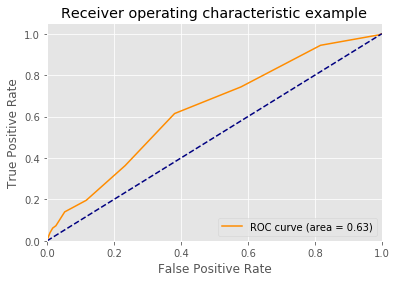

In [246]:
# Using ccs

y_test = np.asarray(join_ccs['Death']);
y_score= np.asarray(join_ccs['CCS']);
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()